## TODO
1. n*thre -> n*std DONE
2. visualization, result table
3. report


In [85]:
count = 0
count_neg_ret = 0
for table in test_list:
    table['cum_ret'] = table['daily_ret'].cumsum()

    if table['nav_cumprod'].iloc[-1] < 1:
        count += 1
    if (table['nav_cumprod'] < 0).any():
        count_neg_ret += 1
print(count)

# 爆仓
print(count_neg_ret)

33
2


# results visualization

In [86]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates



with open('output_MRP/test_tables_train8_test2.pkl', 'rb') as file:
    test_list = pickle.load(file)

with open('output_MRP/train_tables_train8_test2.pkl', 'rb') as file:
    train_list = pickle.load(file)

## preprocesisng, get nav columns

def generate_nav_columns(table):
    table['nav_cumprod'] = (table['daily_ret'] + 1).cumprod()
    table['nav_cumsum'] = (table['daily_ret']).cumsum() + 1
    return table

for idx in range(len(test_list)):
    test_list[idx] = generate_nav_columns(test_list[idx])
    train_list[idx] = generate_nav_columns(train_list[idx])


## Part I: statistics report

In [87]:
table = test_list[0]

def trade_table_statistics(table):
    # 1. calcualte number of openings/closings achieved during the period
    prev_pos = table['position'].shift(1)
    prev_pos.iloc[0] = 0
    mask = (table['position'] == 0)
    num_closings = np.sum(np.abs(prev_pos[mask]))

    mask = (prev_pos == 0)
    num_openings = np.sum(np.abs(table['position'][mask]))


    # 2. nav value
    nav_cumprod = table['nav_cumprod'].iloc[-1]
    nav_cumsum = table['nav_cumsum'].iloc[-1]


    # 3. start_date and end_date
    start_date = table.index[0]
    end_date = table.index[-1]


    # 4. sharpe ratio (daily basis)
    sharpe_daily = np.mean(table['daily_ret']) / np.std(table['daily_ret'])

    # 5. average daily ret
    average_daily_ret = np.mean(table['daily_ret'])

    # 6. average holding period
    def calculate_holding_periods(position_series):
        total_holding_days = 0
        total_num_opens = 0
        curr_open = False

        for position in position_series:
            if not curr_open:
                if position != 0:
                    curr_open = True
                    total_num_opens += 1
            else:
                total_holding_days += 1
                if position == 0:
                    curr_open = False
        average_holding_period = total_holding_days / total_num_opens

        return average_holding_period
    position_series = table['position']
    average_holding_period = calculate_holding_periods(position_series)

    stats = {
        'start_date': start_date,
        'end_date': end_date,

        'sharpe_daily': sharpe_daily,
        'nav_cumprod': nav_cumprod,
        'nav_cumsum': nav_cumsum,
        'average_daily_ret': average_daily_ret,

        'num_openings': num_openings,
        'num_closings': num_closings,
        'average_holding_period': average_holding_period,
    }
    return stats


def create_stats_summary(table_list):
    summary_df = pd.DataFrame()
    
    for table in table_list:

        stats = trade_table_statistics(table)
        stats_df = pd.DataFrame([stats])
        summary_df = pd.concat([summary_df, stats_df], ignore_index=True)
    
    summary_df['num_closings'] = summary_df['num_closings'].astype('int')
    summary_df['num_openings'] = summary_df['num_openings'].astype('int')
    summary_df['average_holding_period'] = summary_df['average_holding_period'].astype('int')
    return summary_df

stats_df = create_stats_summary(test_list)
stats_df.head()

,start_date,end_date,sharpe_daily,nav_cumprod,nav_cumsum,average_daily_ret,num_openings,num_closings,average_holding_period
0,1990-08-29,1990-10-26,-0.041750,0.364530,0.692053,-0.007332,1,0,41
1,1990-10-26,1990-12-26,0.183091,2.082040,2.259452,0.029987,5,4,6
2,1990-12-26,1991-02-25,-0.008394,0.051629,0.915796,-0.002005,3,2,11
3,1991-02-25,1991-04-24,0.575631,22.528798,4.644853,0.086782,9,8,3
4,1991-04-24,1991-06-21,0.150756,1.560337,2.069693,0.025469,3,2,12


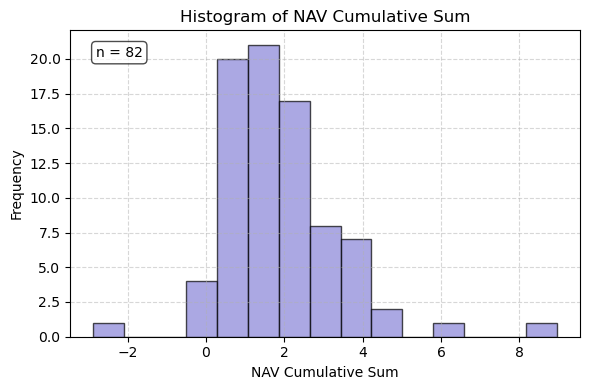

In [88]:
# Plot 1: Histogram of nav_cumsum

def plot_nav_cumsum(stats_df):
    plt.figure(figsize=(6, 4))
    plt.hist(stats_df['nav_cumsum'], bins=15, color='#8884d8', alpha=0.7, edgecolor='black')
    plt.title('Histogram of NAV Cumulative Sum')
    plt.xlabel('NAV Cumulative Sum')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.text(0.05, 0.95, f'n = {len(stats_df)}', transform=plt.gca().transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    plt.tight_layout()
    plt.show()
plot_nav_cumsum(stats_df)

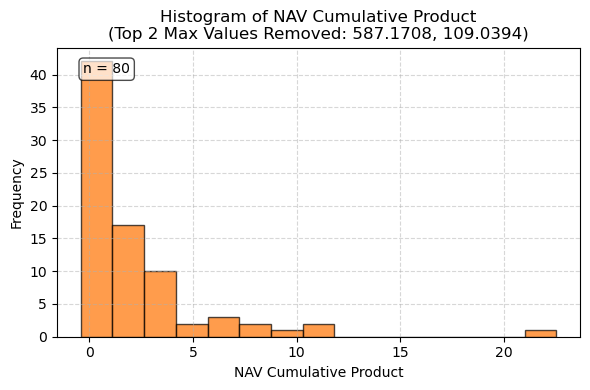

In [89]:

def plot_nav_cumprod(stats_df):
    # Histogram of nav_cumprod (excluding top 2 max values)
    plt.figure(figsize=(6, 4))
    nav_cumprod_filtered = stats_df['nav_cumprod'].copy()

    # Get top 2 max values and their indices
    sorted_values = nav_cumprod_filtered.sort_values(ascending=False)
    max_indices = sorted_values.index[:2]
    max_values = sorted_values.iloc[:2]

    # Remove the top 2 max values
    nav_cumprod_filtered = nav_cumprod_filtered.drop(max_indices)

    plt.hist(nav_cumprod_filtered, bins=15, color='#ff7300', alpha=0.7, edgecolor='black')
    plt.title(f'Histogram of NAV Cumulative Product\n(Top 2 Max Values Removed: {max_values.iloc[0]:.4f}, {max_values.iloc[1]:.4f})')
    plt.xlabel('NAV Cumulative Product')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.text(0.05, 0.95, f'n = {len(nav_cumprod_filtered)}', transform=plt.gca().transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    plt.tight_layout()
    plt.show()
plot_nav_cumprod(stats_df)

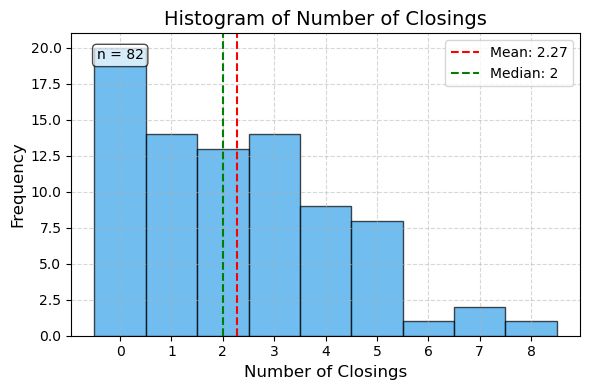

In [90]:
import matplotlib.pyplot as plt
import numpy as np


def plot_num_closings(stats_df):
    plt.figure(figsize=(6, 4))
    plt.hist(stats_df['num_closings'], bins=range(min(stats_df['num_closings']), max(stats_df['num_closings'])+2), 
            color='#36A2EB', alpha=0.7, edgecolor='black', align='left')

    plt.title('Histogram of Number of Closings', fontsize=14)
    plt.xlabel('Number of Closings', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.5)

    plt.xticks(range(min(stats_df['num_closings']), max(stats_df['num_closings'])+1))

    mean_closings = stats_df['num_closings'].mean()
    median_closings = stats_df['num_closings'].median()

    plt.axvline(mean_closings, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_closings:.2f}')
    plt.axvline(median_closings, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_closings:.0f}')


    plt.text(0.05, 0.95, f'n = {len(stats_df)}', transform=plt.gca().transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    plt.legend()
    plt.tight_layout()
    plt.show()

plot_num_closings(stats_df)

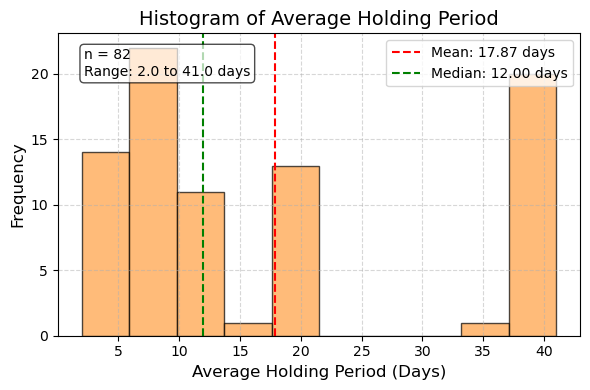

In [91]:
import matplotlib.pyplot as plt
import numpy as np

def plot_average_holding_period(stats_df):
    plt.figure(figsize=(6, 4))

    data = stats_df['average_holding_period']
    n_bins = min(20, max(10, int(np.sqrt(len(data)))))  # Dynamic bin count based on data size


    plt.hist(data, bins=n_bins, color='#FF9F40', alpha=0.7, edgecolor='black')

    plt.title('Histogram of Average Holding Period', fontsize=14)
    plt.xlabel('Average Holding Period (Days)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)


    mean_period = data.mean()
    median_period = data.median()

    plt.axvline(mean_period, color='red', linestyle='dashed', linewidth=1.5, 
                label=f'Mean: {mean_period:.2f} days')
    plt.axvline(median_period, color='green', linestyle='dashed', linewidth=1.5, 
                label=f'Median: {median_period:.2f} days')


    min_period = data.min()
    max_period = data.max()
    plt.text(0.05, 0.95, f'n = {len(data)}\nRange: {min_period:.1f} to {max_period:.1f} days', 
            transform=plt.gca().transAxes, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


    plt.legend()
    plt.tight_layout()
    plt.show()

plot_average_holding_period(stats_df)

## Part II: trading snapshot

In [92]:

def plot_trading_snapshot(trade_table):
    dates = trade_table.index

    start_date = dates[0]
    end_date = dates[-1]

    # Create figure with subplots
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 10), sharex=True)
    # fig.suptitle(f"Traing Snapshot, start={start_date.strftime('%Y-%m-%d')}, end={end_date.strftime('%Y-%m-%d')}", 
    #              fontsize=16)

    # Format x-axis dates
    date_format = mdates.DateFormatter('%Y-%m-%d')
    for ax in [ax1, ax2, ax3, ax4]:
        ax.xaxis.set_major_formatter(date_format)
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
        ax.grid(True, linestyle='--', alpha=0.7)

    # 1. Portfolio nav over time
    ax1.plot(dates, trade_table['nav_cumsum'], color='#8884d8', linewidth=2, label='nav_cumsum', alpha=0.7)
    ax1.plot(dates, trade_table['nav_cumprod'], linewidth=2, label='nav_cumprod', alpha=0.7)
    ax1.set_ylabel('nav')
    ax1.set_title("Portfolio Net Asset Value Over Time")
    ax1.legend()

    # 2. Holding position over time
    ax2.step(dates, trade_table['position'], color='#ff5722', linewidth=2, where='post')
    ax2.set_title('Holding Position Over Time')
    ax2.set_ylabel('position')
    ax2.set_yticks([-1, 0, 1])
    ax2.set_yticklabels(['Short', 'Closed', 'Long'])
    ax2.set_ylim(-1.5, 1.5)


    # 3. Stock prices over time
    ax3.plot(dates, trade_table['portfolio_value'], color='#ff7300', linewidth=2)
    ax3.set_ylabel('asset value')
    ax3.set_title('Underlying Asset Value Over Time')


    # 4. Improved residuals plot
    residuals = trade_table['residuals']
    thr = trade_table['threshold'].iloc[0]

    ax4.plot(dates, residuals, color='#1f77b4', linewidth=1.5)
    ax4.axhline(y=thr, color='#2ca02c', linestyle='--', linewidth=1.5, label=f'long threshold', alpha=0.5)
    ax4.axhline(y=-thr, color='#d62728', linestyle='--', linewidth=1.5, label=f'short threshold', alpha=0.5)

    ax4.set_title('OLS Residuals Over Time')
    ax4.set_ylabel('residuals')
    ax4.legend(loc='best')

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    plt.show()

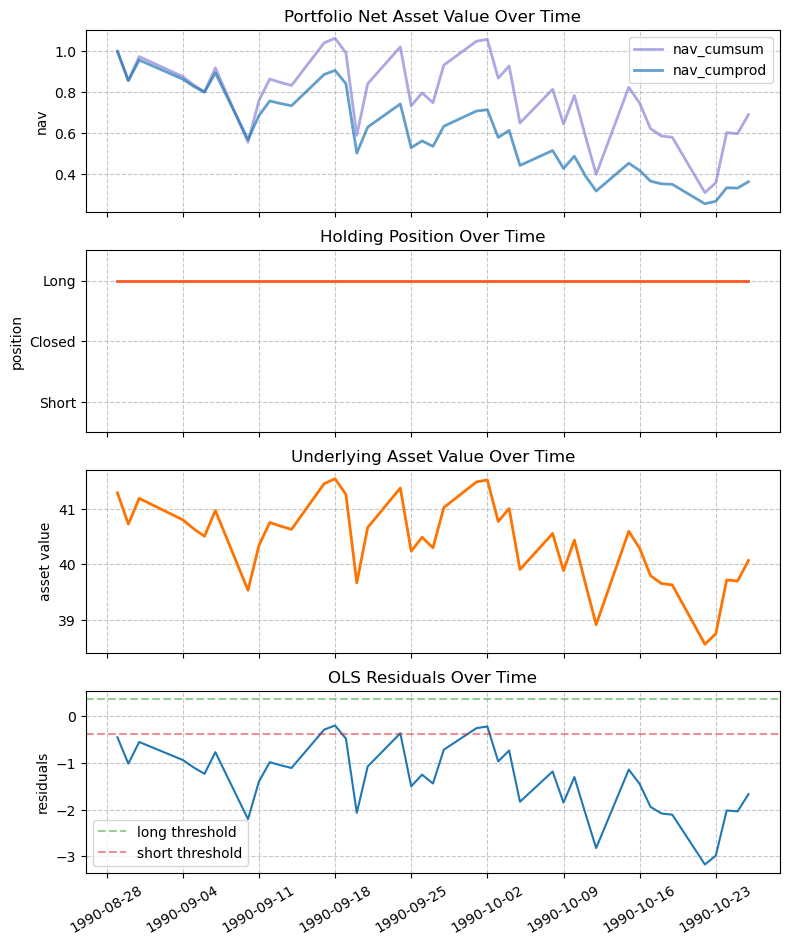

In [93]:
idx=0
table = test_list[idx]

plot_trading_snapshot(table)

# Part III: abnormal cumulative product nav

In [94]:
#异常数据处理
nav_cumprod_filtered = stats_df['nav_cumprod'].copy()

sorted_values = nav_cumprod_filtered.sort_values(ascending=False)
max_indices = sorted_values.index[:2]
max_values = sorted_values.iloc[:2]

idx_0 = max_indices[0]
idx_1 = max_indices[1]

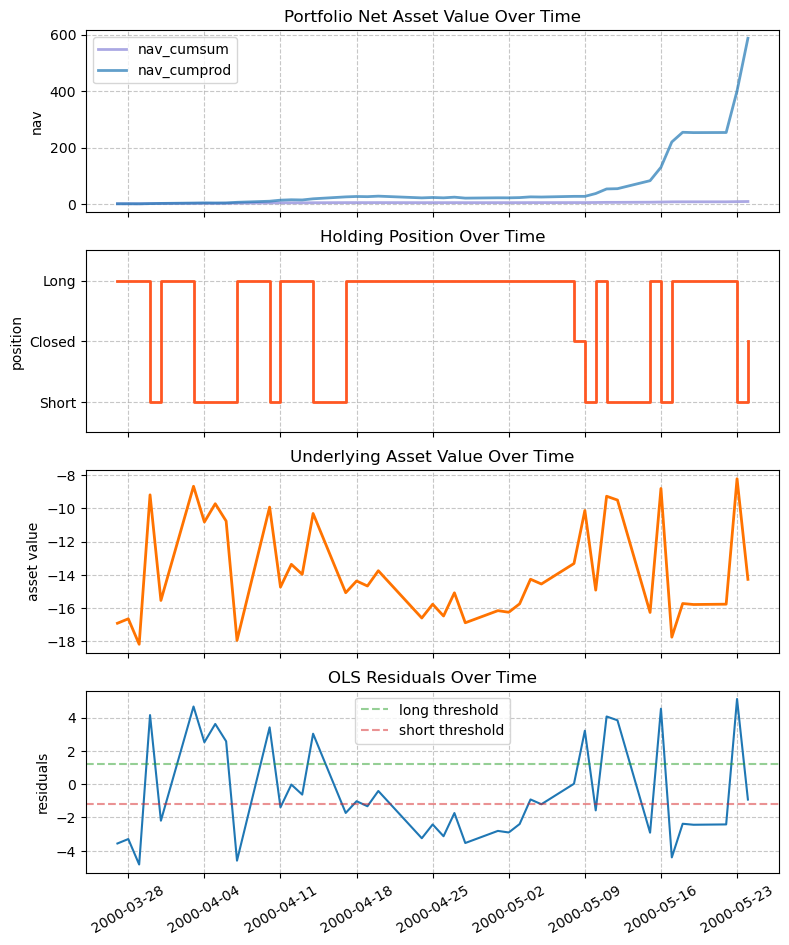

In [95]:
plot_trading_snapshot(test_list[idx_0])

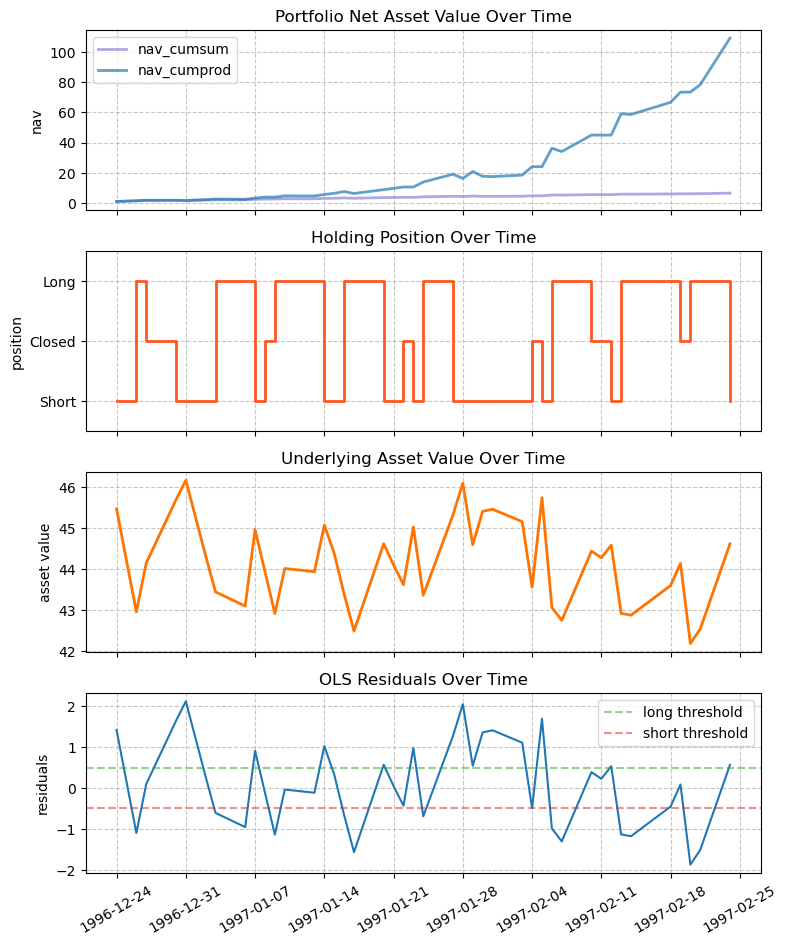

In [96]:
plot_trading_snapshot(test_list[idx_1])